# Udacity Lyft Challenge

This notebook present the code used to train a CNN to tackle the Udacity Lyft challenge.
It is a image segmentation challenge for self driving car. Images are produced from a simulator named  [CARLA](http://carla.org/).


In [1]:
'''Imports'''

import cv2

import matplotlib.pyplot as plt
import numpy             as np

from keras.models              import Model, load_model
from keras.layers              import Input,Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Concatenate, Activation
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.optimizers          import Adam
from keras.losses              import binary_crossentropy
from keras.callbacks           import ModelCheckpoint
from keras                     import backend as K

from PIL   import Image, ImageEnhance
from tqdm  import tqdm
from scipy import ndimage

%matplotlib inline


/home/ongxa/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''Define a set of constants'''


# Constants
TRAIN_IMAGE_FOLDER       = './Data/Train/CameraRGB'
TRAIN_CAMSEG_FOLDER      = './Data/Train/CameraSeg'
TRAIN_LABEL_FOLDER       = './Data/Train/Label'

VAL_IMAGE_FOLDER       = './Data/Validation/CameraRGB'
VAL_CAMSEG_FOLDER      = './Data/Validation/CameraSeg'
VAL_LABEL_FOLDER       = './Data/Validation/Label'


# Crop the sky and the hood
CROP_REGION = (0,200,800,525)

# Define the image size to be near the aspect ratio
# And as well a multiple of 32, as the network scale down to 1/32
NET_INPUT_IMG_SIZE    = (224,544)

# New crop region to focus on small cars
# This is a centered region of size NET_INPUT_IMG_SIZE
CROP_REGION_FOCUS = (128,188,672,412)


# Image generators
train_datagen = ImageDataGenerator(
        rescale=1./255.,
        shear_range=0.2,
        rotation_range=20.,
        horizontal_flip=True,
        vertical_flip=False)

eval_datagen = ImageDataGenerator(rescale=1./255)

# Range of data
train_ids      = np.array(range(7000))
val_ids        = np.array(range(1000))


# Making sure the Label folders exist
!mkdir -m755 -p ./Data/Train/Label
!mkdir -m755 -p ./Data/Validation/Label


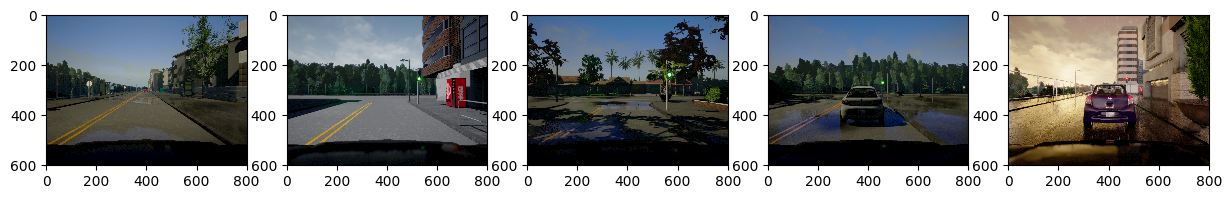

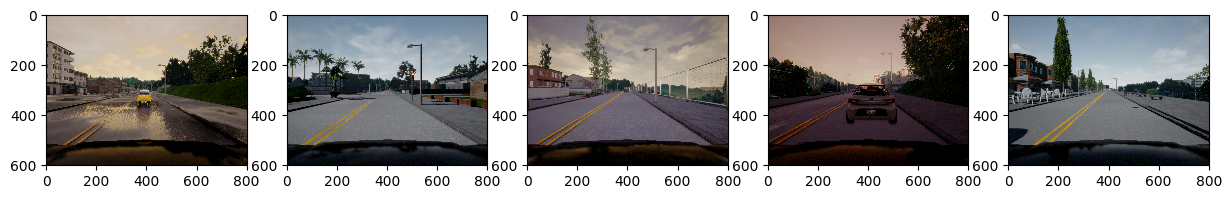

In [3]:
# Exmple of the training set
ix = 0
for img_id in np.random.choice(train_ids, size=10):
    img   = Image.open(f'{TRAIN_IMAGE_FOLDER}/{img_id}.png')
    if ix == 0:
        plt.figure(dpi=100, figsize=(15,15))
    plt.subplot(1,5,ix+1)
    plt.imshow(img)
    ix += 1
    ix %= 5
    if ix == 0:
        plt.show()


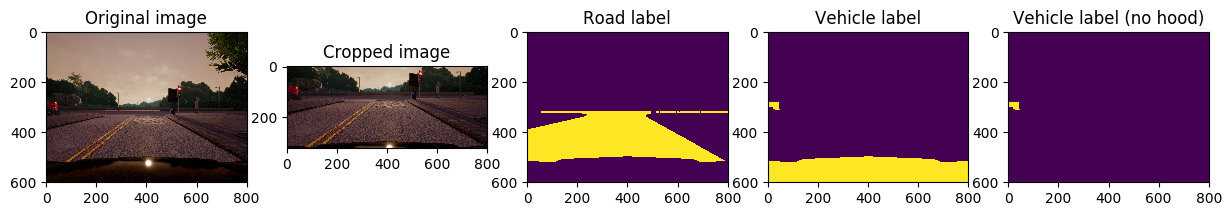

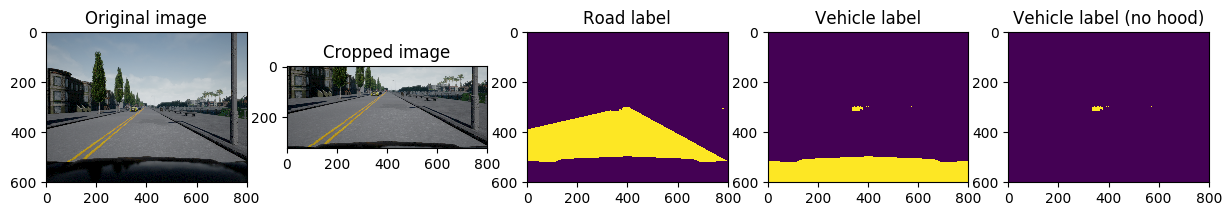

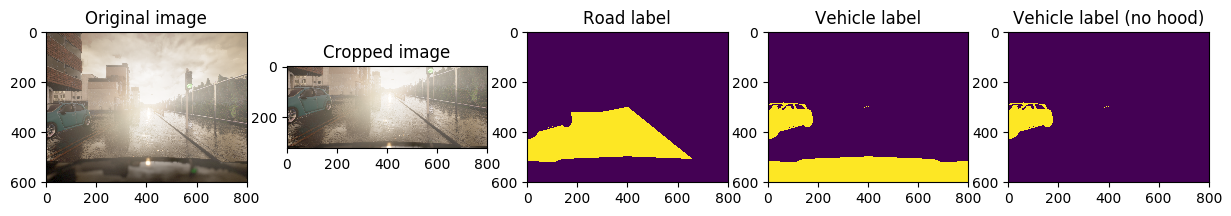

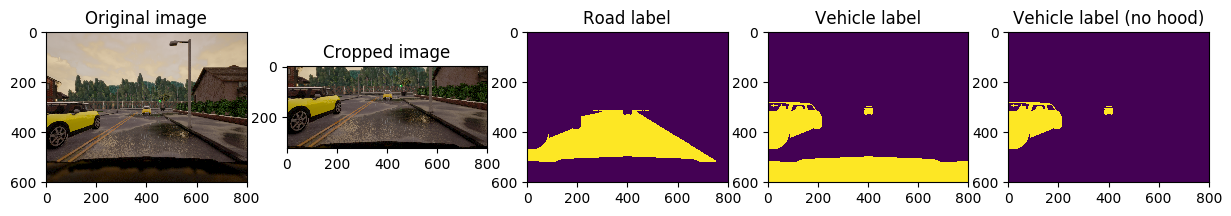

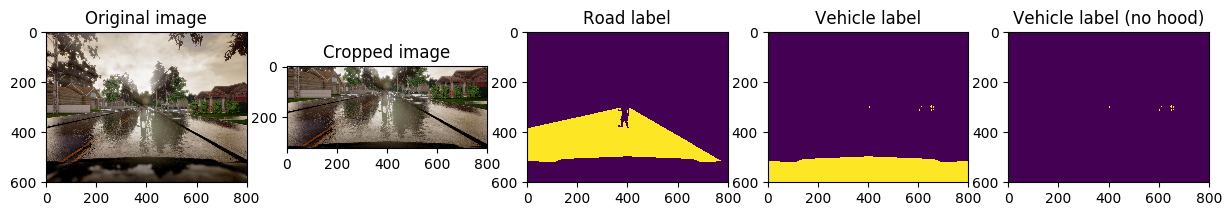

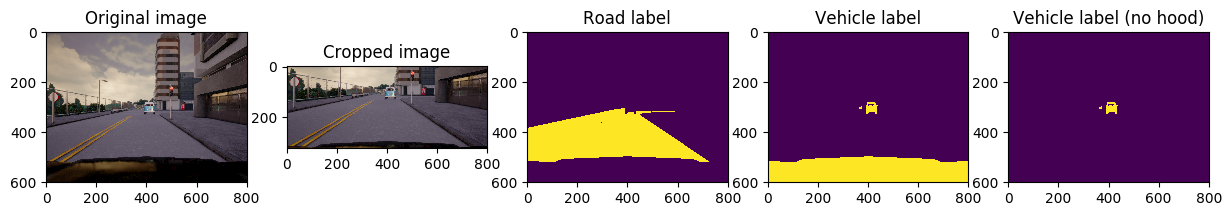

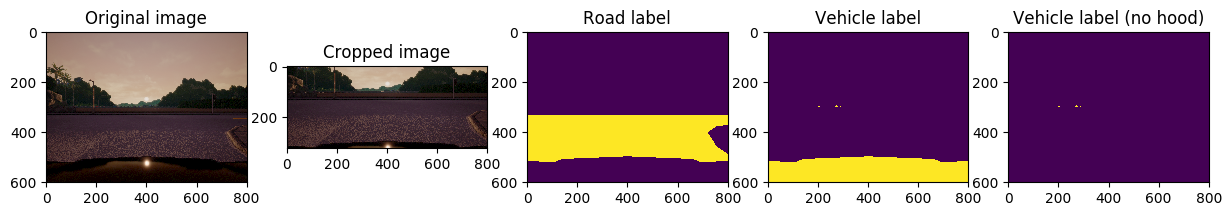

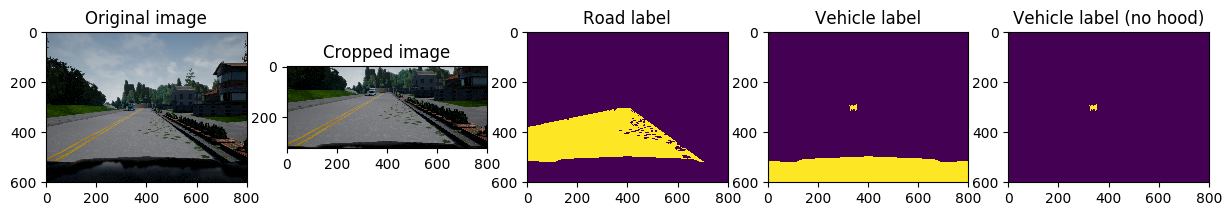

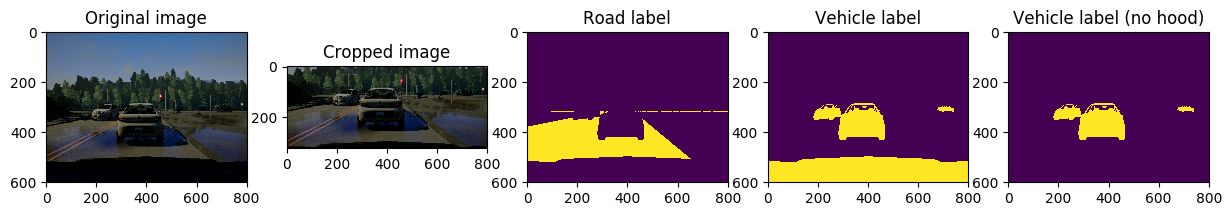

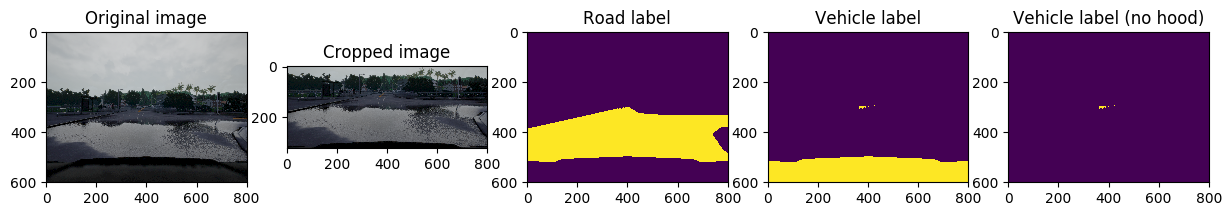

In [4]:
# Exmple of the training set with their labels
ix = 1
for img_id in np.random.choice(train_ids, size=10):
    img   = Image.open(f'{TRAIN_IMAGE_FOLDER}/{img_id}.png')
    img_crop = img.crop(CROP_REGION)
    label = img_to_array(Image.open(f'{TRAIN_CAMSEG_FOLDER}/{img_id}.png'))[:,:,0].astype(np.int32)
    # Merge label 6=roadlines to 7=road
    label_road = np.zeros(label.shape)
    label_road[label == 6] = 1
    label_road[label == 7] = 1
    # Keep only 10=vehicles
    label_vehicle = np.zeros(label.shape)
    label_vehicle[label == 10] = 1
    blobs, nblobs = ndimage.label(label_vehicle)
    v = blobs[590, 400]
    f = np.copy(label_vehicle)
    f[blobs == v] = 0
    plt.figure(dpi=100, figsize=(15,10))
    plt.subplot(151)
    plt.title('Original image')
    plt.imshow(img)
    plt.subplot(152)
    plt.title('Cropped image')
    plt.imshow(img_crop)
    plt.subplot(153)
    plt.title('Road label')
    plt.imshow(label_road)
    plt.subplot(154)
    plt.title('Vehicle label')
    plt.imshow(label_vehicle)
    plt.subplot(155)
    plt.title('Vehicle label (no hood)')
    plt.imshow(f)
    plt.show()
    ix += 1
    

    

### Convert labels from CARLA to the challenge one

We need to convert the segmented images provided by CARLA, those contains 14 classes where we just need the vehicles and the road surface.

At the same time we remove the hood of our car and merge the road surface and road lines label.

In [ ]:
def convert_carlaseg_to_challengeseg(ids, seg_folder=TRAIN_CAMSEG_FOLDER, out_folder=TRAIN_LABEL_FOLDER):
    '''
        Convert the segmented images from CARLA to the challenge format.
        Keep only the vehicles and merge road and roadlines into one class.
        It also removes the hood as it is not part of the challenge evaluation
        
        ids : list of ids to retrieve images from the folder
        seg_folder : Folder where the CARLA segmented images reside
        out_folder : Folder where the challenge segmented image will be saved
    '''
    # Loop over all images
    for img_id in tqdm(ids):
        img_seg = img_to_array(Image.open(f'{seg_folder}/{img_id}.png')).astype('uint8')
        labels = img_seg[:,:,0]
        
        # Merge label 6=roadlines and 7=road
        label_road = np.where(np.logical_or(labels == 6, labels == 7), 1, 0).astype('uint8')
        # Keep only 10=vehicles
        label_vehicle = np.where(labels == 10, 1, 0).astype('uint8')

        # Remove the hood by remove the blob close to the bottom
        blobs, nblobs = ndimage.label(label_vehicle)
        blob_num = blobs[590, 400]
        label_vehicle[blobs == blob_num] = 0

        # Combine both in one image
        # Channel 0 -> Road
        # Channel 1 -> vehicle
        img_seg[:,:,0] = label_road
        img_seg[:,:,1] = label_vehicle

        # Save it back
        img = Image.fromarray(img_seg).convert('RGB')
        img.save(f'{out_folder}/{img_id}.png')
        

In [ ]:
# Prepare our label files, with only what we need in 2 channels
convert_carlaseg_to_challengeseg(train_ids     , seg_folder=TRAIN_CAMSEG_FOLDER, out_folder=TRAIN_LABEL_FOLDER)
convert_carlaseg_to_challengeseg(val_ids       , seg_folder=VAL_CAMSEG_FOLDER, out_folder=VAL_LABEL_FOLDER)


### Data generation

For our training we need to generate batches.
The function data_generator is used to generate batches with augmentation for the training.

The augmentation is controlled by 2 parameters
- data_generator     : This is an instance of ImageDataGenerator from keras that define the geometric transformation
- color_augmentation : Boolean to add brightness and contrast augmentation


In [5]:
def data_generator(data_ids,img_size=NET_INPUT_IMG_SIZE, 
                   crop_region = CROP_REGION,crop_region_focus=CROP_REGION_FOCUS,
                   batch_size=4,
                   img_folder=TRAIN_IMAGE_FOLDER,label_folder=TRAIN_LABEL_FOLDER,
                   data_generator = ImageDataGenerator(rescale=1./255),
                   color_augmentation=False, car_minimum_pixel = 0, shufle_data=False
                  ):
    
    if shufle_data:
        img_ids = np.random.choice(data_ids,size=data_ids.shape[0],replace=False)
    else:
        img_ids = data_ids

    li = 0
    while True:
        X_batch_0 = []
        X_batch_1 = []
        y_batch = []
        for batch_i in range(batch_size):
            img_id = img_ids[li]
            seed = np.random.randint(1e6)

            # Make sure we get cars as this class is represented low
            img_seg = img_to_array(Image.open(f'{label_folder}/{img_id}.png').crop(crop_region))
            while np.sum(img_seg[:,:,1]) < car_minimum_pixel:
                # Next id
                li = (li + 1) % data_ids.shape[0]
                # Resuffle the ids if back to 0
                if li == 0 and shufle_data:
                    img_ids = np.random.choice(data_ids,size=data_ids.shape[0],replace=False)
                img_id = img_ids[li]
                img_seg = img_to_array(Image.open(f'{label_folder}/{img_id}.png').crop(crop_region))
            
            # Get the input image
            img_i = Image.open(f'{img_folder}/{img_id}.png')
            
            # Update contrast
            if color_augmentation and np.random.randint(2) == 1:
                enhancer = ImageEnhance.Contrast(img_i)
                img_i = enhancer.enhance(np.random.uniform(0.5,2.))

            # Update brightness
            if color_augmentation and np.random.randint(2) == 1:
                enhancer = ImageEnhance.Brightness(img_i)
                img_i = enhancer.enhance(np.random.uniform(0.5, 2.))

            # Get bot image for the network
            img_input = img_to_array(img_i.crop(crop_region).resize((img_size[1], img_size[0])))
            # Use the data generator to augment the image
            img_input = next(data_generator.flow(x=np.array([img_input]), batch_size=1, seed=seed))[0]
            
            img_focus = img_to_array(img_i.crop(crop_region_focus))
            # Use the data generator to augment the image
            img_focus = next(data_generator.flow(x=np.array([img_focus]), batch_size=1, seed=seed))[0]

            # Now get the labels
            img_seg = img_to_array(Image.open(f'{label_folder}/{img_id}.png').crop(crop_region).resize((img_size[1], img_size[0])))
            # Use the data generator to augment the labels the same way, use the same seed
            img_seg = next(data_generator.flow(x=np.array([img_seg]), batch_size=1, seed=seed))[0]
            # Need to put back only 0 and 1 due to transformation
            img_seg = np.where(img_seg > 0., 1., 0.)
            
            # Keep only the channels 0 and 1
            y = img_seg[:,:,:2]
                
            # Add this image to our batch
            X_batch_0.append(img_input)
            X_batch_1.append(img_focus)
            y_batch.append(y)
            
            # Next id
            li = (li + 1) % data_ids.shape[0]
            # Resuffle the ids if back to 0
            if li == 0 and shufle_data:
                img_ids = np.random.choice(data_ids,size=data_ids.shape[0],replace=False)


        yield [np.array(X_batch_0),np.array(X_batch_1)], np.array(y_batch)

#### Data generator example with geometric and color augmentation

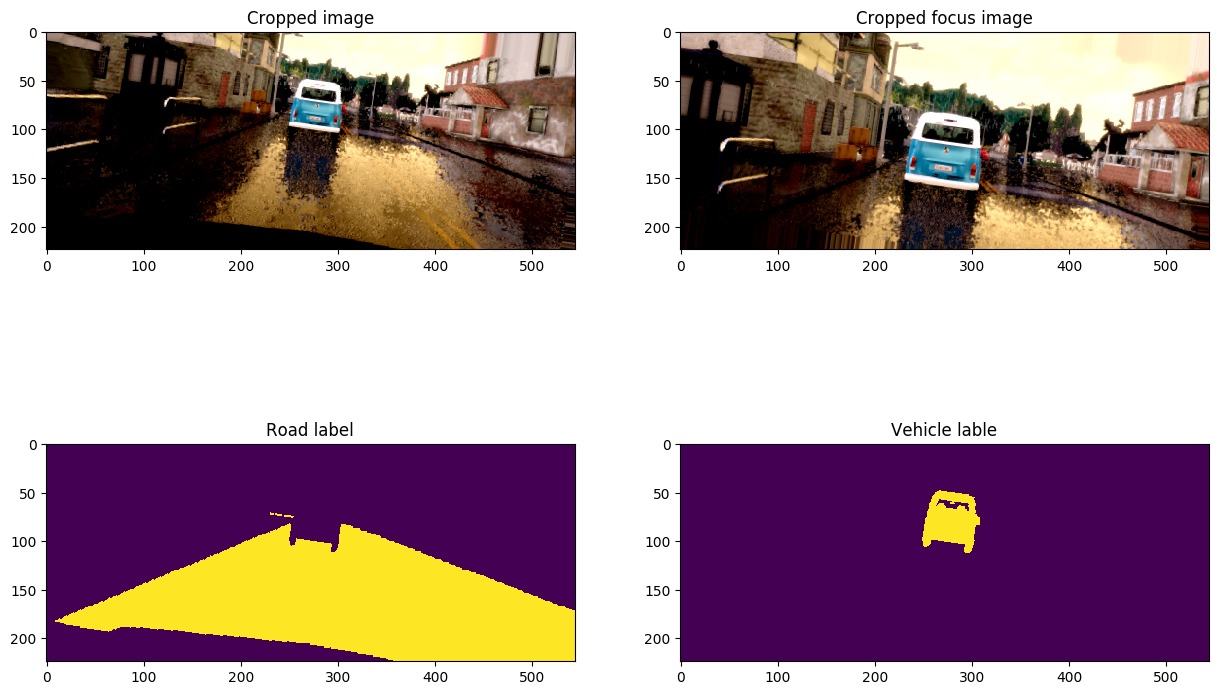

In [6]:
# Get the generator
batch_generator = data_generator(data_ids=train_ids,batch_size=4, data_generator=train_datagen,
                                 color_augmentation=True, car_minimum_pixel = 1, shufle_data=True)


# Get the next batch
X,y = next(batch_generator)
plt.figure(dpi=100, figsize=(15,10))
plt.subplot(221)
plt.title('Cropped image')
plt.imshow(X[0][0])
plt.subplot(222)
plt.title('Cropped focus image')
plt.imshow(X[1][0])
plt.subplot(223)
plt.title('Road label')
plt.imshow(y[0][:,:,0])
plt.subplot(224)
plt.title('Vehicle lable')
plt.imshow(y[0][:,:,1])
plt.show()

### Network

The network architecture used is a  [U-net](https://arxiv.org/pdf/1505.04597.pdf) like network.

Each layer use the sequence Convolution -> Batchnorm -> Activation. This has proven to reduce overfitting and i don't even need any Dropout layer.

Then we have the encoder which use a bunch of down_stack:
    - 1 or more ConvBnActivation
    - Max pooling at the last layer
    
Then the decoder is using a bunch of up_stack:
    - Up sample the previous layer
    - Merge with a lower layer features
    - 1 or more ConvBnActivation

In [ ]:
#Unit logic for our network
def ConvBnActivation(filters, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', dilation_rate=(1, 1), name=None):
    def f(input_tensor):
        out = Conv2D(filters, kernel_size=kernel_size, strides=strides,  padding = padding,dilation_rate=dilation_rate,
                     kernel_initializer = 'he_normal')(input_tensor)
        out = BatchNormalization()(out)
        return Activation(activation, name=name)(out)
    return f


def down_stack(in_tensor, filters, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', n_conv=1):
    conv = ConvBnActivation(filters, kernel_size, strides, padding,activation)(in_tensor)
    for _ in range(n_conv):
        conv = ConvBnActivation(filters, kernel_size, strides, padding,activation)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    
    return conv, pool

def up_stack(in_tensor, concat_tensor, filters, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu',  n_conv=1):
    up    = ConvBnActivation(filters, kernel_size, strides, padding,activation)(UpSampling2D(size = (2,2))(in_tensor))
    merge = Concatenate(axis = 3)([ConvBnActivation(filters , kernel_size=(1,1))(concat_tensor),up])
    conv  = ConvBnActivation(filters, kernel_size, strides, padding,activation)(merge)
    for _ in range(n_conv):
        conv  = ConvBnActivation(filters, kernel_size, strides, padding,activation)(conv)
    return conv


In [ ]:
def get_unet(input_shape=(512,512,3)):

    input_i = Input(shape=input_shape, name='img_i')
    input_f = Input(shape=input_shape, name='img_f')
    
    conv_i = ConvBnActivation(16, kernel_size=(5,5))(input_i)
    conv_i = ConvBnActivation(32)(conv_i)
    
    conv_f = ConvBnActivation(16)(input_f)
    conv_f = ConvBnActivation(32)(conv_f)
        
    conv_if = Concatenate(axis = 3)([conv_i,conv_f])

    conv1, pool1 = down_stack(conv_if, 32 , n_conv=0)
    conv2, pool2 = down_stack(pool1  , 64 , n_conv=0)
    conv3, pool3 = down_stack(pool2  , 128, n_conv=0)
    conv4, pool4 = down_stack(pool3  , 256, n_conv=0)
    conv5, pool5 = down_stack(pool4  , 512, n_conv=0)

    center = ConvBnActivation(768)(pool5)

    up5 = up_stack(center, conv5, 512, kernel_size=(2,2), n_conv=0)
    up4 = up_stack(up5   , conv4, 256, kernel_size=(2,2), n_conv=0)
    up3 = up_stack(up4   , conv3, 128, kernel_size=(2,2), n_conv=0)
    up2 = up_stack(up3   , conv2, 64 , kernel_size=(2,2), n_conv=0)
    up1 = up_stack(up2   , conv1, 32 , kernel_size=(2,2), n_conv=0)


    classifier = ConvBnActivation(2 , kernel_size=(1,1), activation = 'sigmoid', name='class')(up1)

    model = Model(inputs = [input_i, input_f], outputs = classifier)
    
    return model

### Loss

We use the Fscore from the challenge + the binary cross entropy for our loss.

In [7]:
def F_beta_score(y_true, y_pred, beta=1.):
    TP = K.sum(y_pred * y_true) #K.sum(K.logical_and(y_pred == 1, y_true == 1))
    FP = K.sum(y_pred * (1. - y_true)) #K.sum(K.logical_and(y_pred == 1, y_true == 0))
    #TN = K.sum(K.logical_and(y_pred == 0, y_true == 0))
    FN = K.sum((1. - y_pred) * y_true) #K.sum(K.logical_and(y_pred == 0, y_true == 1))

    precision = TP/(TP+FP+K.epsilon())
    recall    = TP/(TP+FN+K.epsilon())
    
    return (1+beta**2) * ((precision*recall)/(beta**2 * precision + recall + K.epsilon()))

def Lyft_car_Fscore(y_true, y_pred):
    return F_beta_score(y_true[:,:,:,1], y_pred[:,:,:,1], beta=2.)

def Lyft_road_Fscore(y_true,y_pred):
    return F_beta_score(y_true[:,:,:,0], y_pred[:,:,:,0], beta=0.5)

def Lyft_FScore(y_true, y_pred):
    return (Lyft_car_Fscore(y_true, y_pred) + Lyft_road_Fscore(y_true, y_pred)) / 2.

def Lyft_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + 1 - Lyft_FScore(y_true,y_pred)


### Training

I use Adam optimizer for 40 epochs

In [ ]:
model = get_unet_v6(input_shape=(NET_INPUT_IMG_SIZE[0],NET_INPUT_IMG_SIZE[1],3))
model.compile(optimizer = Adam(lr = 1e-3), loss = Lyft_loss, metrics = [Lyft_road_Fscore, Lyft_car_Fscore, Lyft_FScore])


In [ ]:
model.summary()

In [ ]:
MCP_callback = ModelCheckpoint(filepath='./models/model-{val_loss:.4f}-{epoch:02d}.h5', monitor='val_loss', save_best_only=False)

BATCH_SIZE = 4
ECPOCHS    = 40

history= model.fit_generator(
         data_generator(data_ids=train_ids, 
                        img_size=NET_INPUT_IMG_SIZE, 
                        crop_region = CROP_REGION,crop_region_focus=CROP_REGION_FOCUS,
                        batch_size=BATCH_SIZE,
                        img_folder=TRAIN_IMAGE_FOLDER,label_folder=TRAIN_LABEL_FOLDER,
                        data_generator=train_datagen,
                        color_augmentation=True, car_minimum_pixel = 1, shufle_data=True)
        ,steps_per_epoch=int(train_ids.shape[0]/ BATCH_SIZE)
        ,epochs=ECPOCHS
        ,validation_data=data_generator(data_ids=val_ids,
                                        img_size=NET_INPUT_IMG_SIZE, 
                                        crop_region = CROP_REGION,crop_region_focus=CROP_REGION_FOCUS,
                                        batch_size=BATCH_SIZE,
                                        img_folder=VAL_IMAGE_FOLDER,label_folder=VAL_LABEL_FOLDER,
                                        data_generator=eval_datagen,
                                        color_augmentation=False, car_minimum_pixel = 1, shufle_data=False)
        ,validation_steps=int(val_ids.shape[0]/ BATCH_SIZE)
        ,callbacks=[MCP_callback]
       )

In [ ]:
#Plot the learning losses
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'g')
plt.show()

In [8]:
# Load the selected model
model = load_model('model.h5', custom_objects={'Lyft_loss'       : Lyft_loss, 
                                                  'Lyft_road_Fscore': Lyft_road_Fscore, 
                                                  'Lyft_car_Fscore' : Lyft_road_Fscore,
                                                   'Lyft_FScore': Lyft_FScore
                                                 })

In [9]:
model.save('model-noop.h5',include_optimizer=False)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_i (InputLayer)              (None, 224, 544, 3)  0                                            
__________________________________________________________________________________________________
img_f (InputLayer)              (None, 224, 544, 3)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 224, 544, 16) 1216        img_i[0][0]                      
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 544, 16) 448         img_f[0][0]                      
__________________________________________________________________________________________________
batch_norm

### Visual evaluation

Here we can visualize how the network predict

In [11]:
def Fscore_beta(y_pred, y_true, beta=1.):
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    
    precision = TP/(TP+FP+1e-9)
    recall    = TP/(TP+FN+1e-9)
    
    return (1+beta**2) * ((precision*recall)/(beta**2 * precision + recall))    

F_road: 0.9968669282087272 -- F_car: 0.9780359867086906 -- F: 0.987451457458709


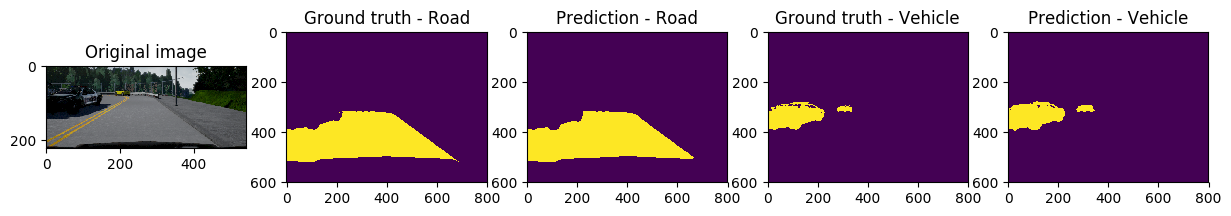

F_road: 0.997129950243243 -- F_car: 0.8812679327770998 -- F: 0.9391989415101714


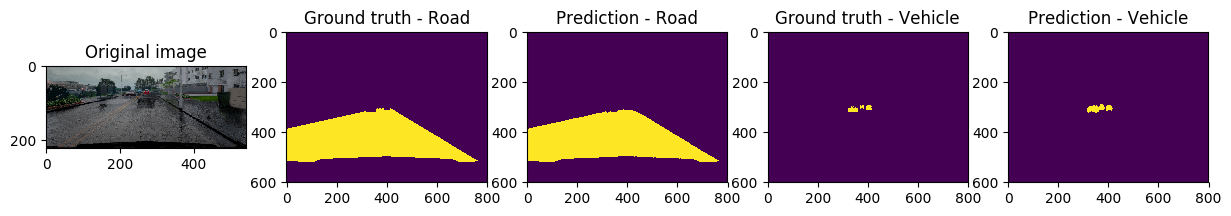

F_road: 0.9794478075782255 -- F_car: 0.9504311466591814 -- F: 0.9649394771187034


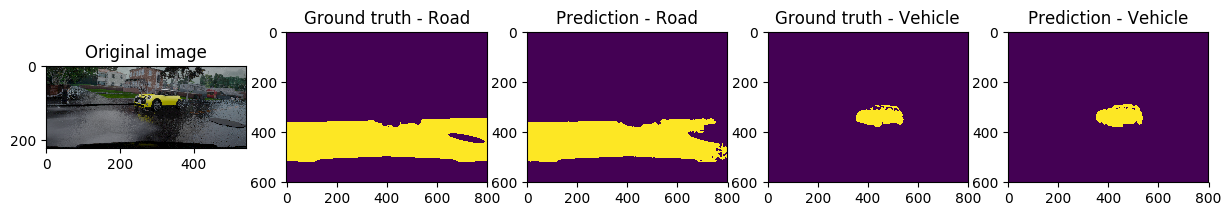

F_road: 0.9856718220240392 -- F_car: 0.9448965877693777 -- F: 0.9652842048967085


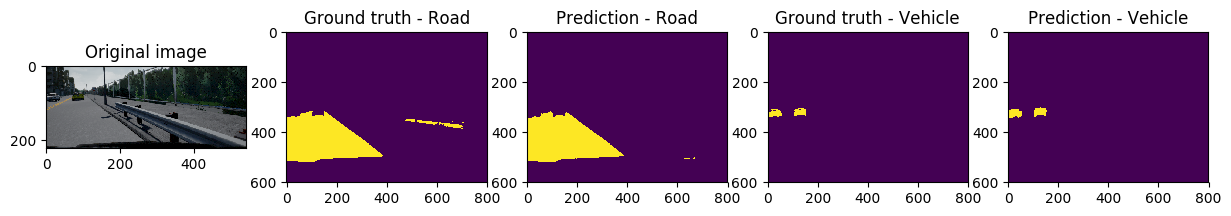

F_road: 0.9967938392328267 -- F_car: 0.9694963895572649 -- F: 0.9831451143950458


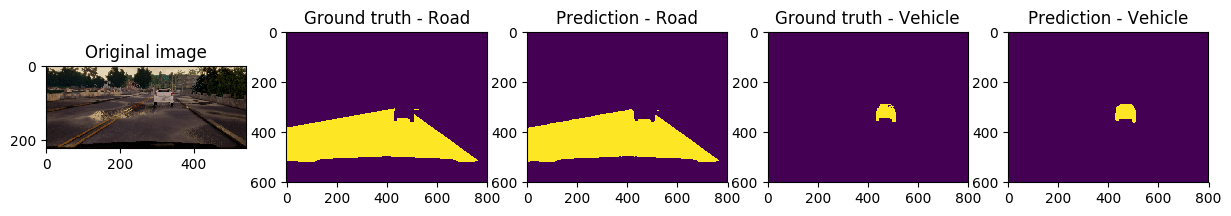

In [13]:
from skimage.transform import resize

for img_id in np.random.choice(val_ids, size=5, replace=False):
    img_i = Image.open(f'{VAL_IMAGE_FOLDER}/{img_id}.png')
    img_input = img_to_array(img_i.crop(CROP_REGION).resize((NET_INPUT_IMG_SIZE[1], NET_INPUT_IMG_SIZE[0])))
    img_input /= 255.

    img_focus = img_to_array(img_i.crop(CROP_REGION_FOCUS))
    img_focus /= 255.
    
    img_gt   = img_to_array(load_img(path=f'{VAL_LABEL_FOLDER}/{img_id}.png')) #, target_size=img_size))
    pred = model.predict_on_batch([np.array([img_input]), np.array([img_focus])])
    pred_r = resize(pred[0], (CROP_REGION[3]-CROP_REGION[1],CROP_REGION[2]-CROP_REGION[0]), mode='reflect')
    
    pp = np.zeros_like(img_gt)
    pp[CROP_REGION[1]:CROP_REGION[3],:,:2] = pred_r
    
    out_road = pp[:,:,0]
    out_car  = pp[:,:,1]
    
    binary_road  = np.where(out_road>0.9,1,0).astype('uint8')
    binary_car   = np.where(out_car>0.6,1,0).astype('uint8')

    F_road = Fscore_beta(binary_road, img_gt[:,:,0], 0.5)
    F_car  = Fscore_beta(binary_car , img_gt[:,:,1], 2)
    
    F = (F_road + F_car) / 2.
    
    print(f'F_road: {F_road} -- F_car: {F_car} -- F: {F}')
    
    plt.figure(dpi=100, figsize=(15,15))
    plt.subplot(151)
    plt.title('Original image')
    plt.imshow(img_input)
    plt.subplot(152)
    plt.title('Ground truth - Road')
    plt.imshow(img_gt[:,:,0])
    plt.subplot(153)
    plt.title('Prediction - Road')
    plt.imshow(binary_road)
    plt.subplot(154)
    plt.title('Ground truth - Vehicle')
    plt.imshow(img_gt[:,:,1])
    plt.subplot(155)
    plt.title('Prediction - Vehicle')
    plt.imshow(binary_car)
    plt.show()
    
    
